# Curso: MCC639E

#### Integrantes

- Carlos Tello Tapia
- Lennin Quiso Córdova
- Milton Palacin Grijalva
___

# SEGUNDA PARTE: EXPLORAR CON TÓPIC MODELING

## I. Declaración de librerías

In [1]:
# Tratamiento de datos
# ==============================================================================
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import mglearn

# Tratamiento de texto
# ==============================================================================
from nltk import FreqDist
from nltk import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from sklearn.manifold import TSNE

# Visualización Jupyter
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## II. Cargar y explorar el dataset

In [2]:
%%time
dataset_base = pd.read_csv("dataset_base.csv", sep='\t', encoding='utf-8')
dataset_base.sample(5)

CPU times: user 954 ms, sys: 95.4 ms, total: 1.05 s
Wall time: 1.05 s


,category,title,date,abstract,content,content_for_summary,abstract_for_summary,content_for_topic,content_for_topic_lemma
3190,JUSTICIA Y DERECHOS HUMANOS,RESOLUCION MINISTERIAL N° 0107-2021-JUS,11/06/2021,Aprueban el Trigésimo Primer Listado de Benefi...,"Lima, 7 de junio de 2021 VISTOS, el Oficio N° ...",lima de junio de vistos el oficio jus se cman ...,aprueban el trigésimo primer listado de benefi...,lima junio vistos oficio cman secretaría ejecu...,lima junio visto oficio cmar secretaría ejecut...
1130,ENERGIA Y MINAS,RESOLUCION MINISTERIAL N° 252-2021-MINEM/DM,23/07/2021,Constituyen el derecho de servidumbre de ocupa...,"Lima, 22 de julio de 2021 VISTOS: El escrito c...",lima de julio de vistos el escrito con registr...,constituyen el derecho de servidumbre de ocupa...,lima julio vistos escrito registro presentado ...,lima julio visto escrito registro presentado e...
3260,SUPERINTENDENCIA NACIONAL DE EDUCACION SUPERIO...,RESOLUCION N° 059-2021-SUNEDU/CD,10/06/2021,Deniegan la modificación de licencia instituci...,"Lima, 8 de junio de 2021 VISTOS: La Solicitud ...",lima de junio de vistos la solicitud de modifi...,deniegan la modificación de licencia instituci...,lima junio vistos solicitud modificación licen...,lima junio visto solicitud modificación licenc...
3258,SEGURO INTEGRAL DE SALUD,RESOLUCION JEFATURAL N° 074-2021/SIS,10/06/2021,Aprueban el Plan de Fortalecimiento de Acceso ...,"Lima, 9 de junio de 2021 VISTOS: El Informe N°...",lima de junio de vistos el informe sis gadj me...,aprueban el plan de fortalecimiento de acceso ...,lima junio vistos informe gadj memorando geren...,lima junio visto informe gadj memorar gerencia...
378,JURADO NACIONAL DE ELECCIONES,RESOLUCION N° 0777-2021-JNE,10/08/2021,Declaran concluido el proceso de Elecciones Ge...,"Lima, seis de agosto de dos mil veintiuno VIST...",lima seis de agosto de dos mil veintiuno visto...,declaran concluido el proceso de elecciones ge...,lima seis agosto veintiuno vistos informes fin...,limo seis agosto veintiuno informe final presi...


In [3]:
print("Total de normas legales en el dataset:", dataset_base.shape[0])

Total de normas legales en el dataset: 4037


CPU times: user 345 ms, sys: 285 µs, total: 345 ms
Wall time: 340 ms


<AxesSubplot:xlabel='count', ylabel='category'>

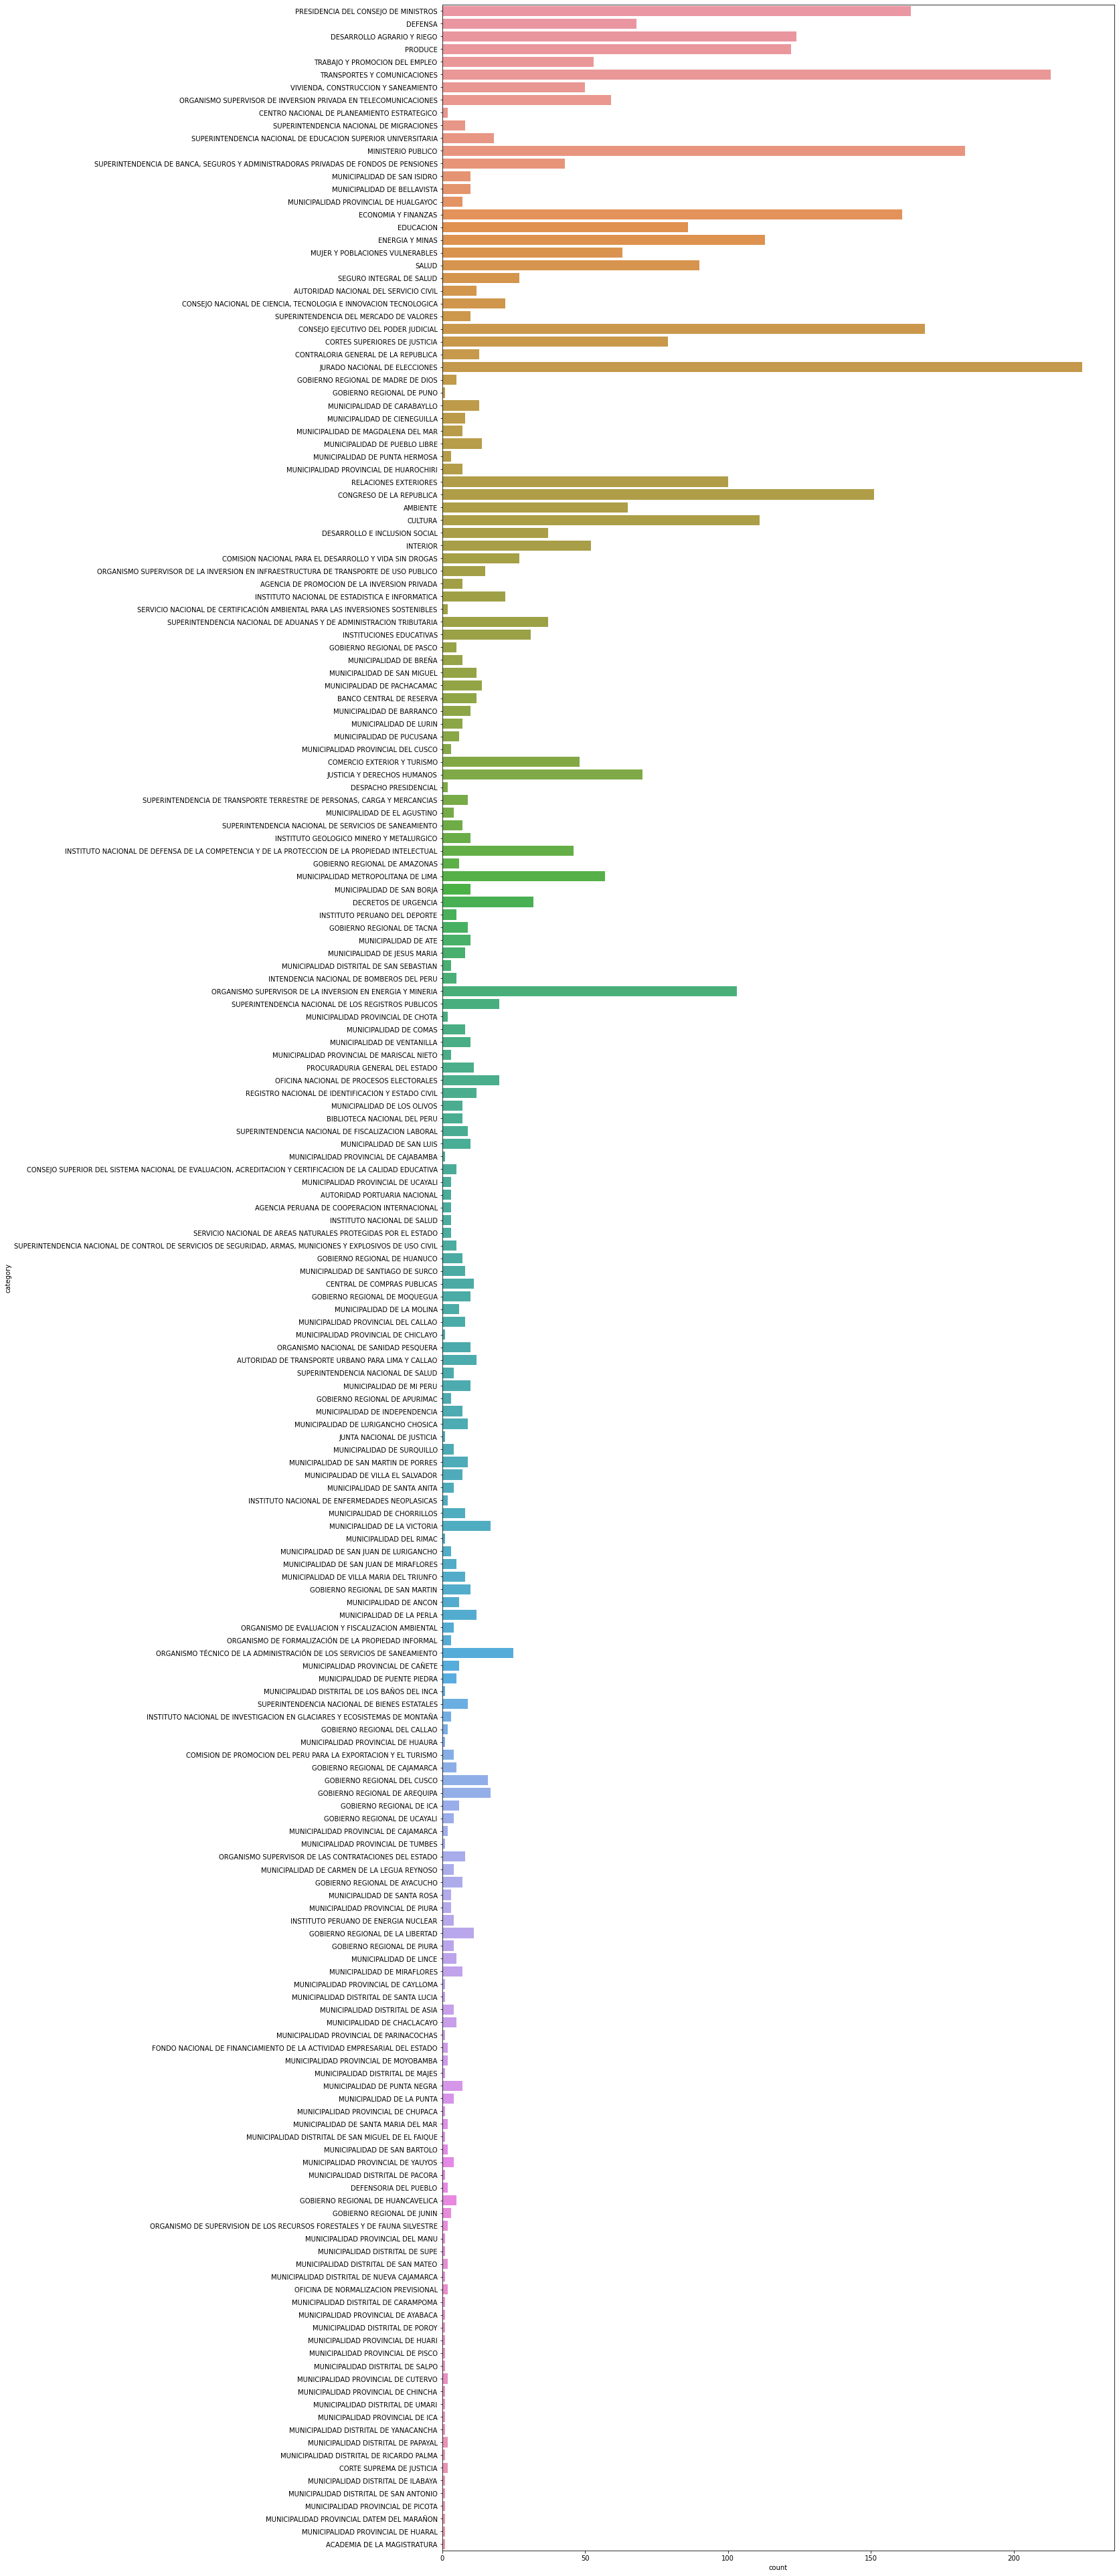

In [4]:
%%time
plt.figure(figsize=(18,70))
sns.countplot(y='category', data=dataset_base, orient='h')

___
Verificación del corpus
___

In [6]:
%%time
frec = FreqDist(word_tokenize(' '.join(dataset_base.content_for_topic_lemma)))
frec.most_common(10)

CPU times: user 12.3 s, sys: 27.6 ms, total: 12.3 s
Wall time: 12.3 s


[('resolución', 25667),
 ('decreto', 24044),
 ('nacional', 21463),
 ('general', 20639),
 ('público', 17865),
 ('presente', 16953),
 ('mediante', 16886),
 ('supremo', 15885),
 ('reglamento', 13728),
 ('informe', 13657)]

In [7]:
# Tamaño de arreglo de palabras
print("Total de palabras del vacabulario:", len(frec))
print("Total de palabras que represetn lso tokens:", frec.N())

Total de palabras del vacabulario: 30380
Total de palabras que represetn lso tokens: 2888275


## III. Configurar el dataset para el Topic Modelling

___
Confirgurar y realizar proceso de vectorización/diccionario del contenido
___

In [9]:
%%time

# Representación vectorizada de todo el texto con TF-IDF
tfidf_model = TfidfVectorizer(
    max_df=0.99, # max_df : Frecuencia máxima de documentos para la palabra procesada
    max_features=20000, # max_features: númerp máximo de palabras
    min_df=0.01, # min_df : Frecuencia mínima para la palabra procesada
    use_idf=True, # use_idf: Si es falso solo calcula TF
    ngram_range=(1,1) # ngram_range: (min, max), p.e. (1, 2)incluye 1-gram, 2-gram
)

# Aplicamos el modelo 
tfidf_matrix = tfidf_model.fit_transform(dataset_base.content_for_topic_lemma) 

print("="*50)
print("En total hay {} filas (normas legales) y {} terminos.".format(
    str(tfidf_matrix.shape[0]), str(tfidf_matrix.shape[1])
))
print("="*50)

En total hay 4037 filas (normas legales) y 3226 terminos.
CPU times: user 1.52 s, sys: 0 ns, total: 1.52 s
Wall time: 1.52 s


___
Realizar validación cruzada para encontrar el mejor número de clusters y learning_decay (Hiperparáemtro).  
Se utiliza Latent Dirichlet Allocation (LDA)
___

In [10]:
%%time

# Prámetros a optimizar
#grid_params = {'n_components': list(range(1,6))}
grid_params = {'n_components': [5, 7, 10], 'learning_decay': [.5, .7, .9]}

# Modelo lda
lda = LatentDirichletAllocation()

#validación cruzada
lda_model = GridSearchCV(lda,param_grid=grid_params, verbose=1, n_jobs=20)
lda_model.fit(tfidf_matrix)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  45 out of  45 | elapsed:  1.4min finished


CPU times: user 9.85 s, sys: 305 ms, total: 10.2 s
Wall time: 1min 32s


GridSearchCV(estimator=LatentDirichletAllocation(), n_jobs=20,
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 7, 10]},
             verbose=1)

In [12]:
%%time
lda_model1 = lda_model.best_estimator_
print("Mejores parámetros para el modelo LDA:" , lda_model.best_params_)
print("Mejor puntage de probabilidad logísticas (veracidad) del modelo LDA",lda_model.best_score_)
print("Compljedidad del modelo LDA", lda_model1.perplexity(tfidf_matrix))

Mejores parámetros para el modelo LDA: {'learning_decay': 0.7, 'n_components': 5}
Mejor puntage de probabilidad logísticas (veracidad) del modelo LDA -64169.26514394696
Compljedidad del modelo LDA 2899.68224189822
CPU times: user 916 ms, sys: 30 µs, total: 916 ms
Wall time: 914 ms


## III. Topic Modelling

___
Ejecutar el modelo con los mejores parámetros (númoer de tópicos y Leaning Rate)
___

In [13]:
%%time
n_topics = 5
n_learning_decay=0.7
lda = LatentDirichletAllocation(n_components=n_topics, learning_decay=n_learning_decay, verbose=True).fit(tfidf_matrix)

iteration: 1 of max_iter: 10
iteration: 2 of max_iter: 10
iteration: 3 of max_iter: 10
iteration: 4 of max_iter: 10
iteration: 5 of max_iter: 10
iteration: 6 of max_iter: 10
iteration: 7 of max_iter: 10
iteration: 8 of max_iter: 10
iteration: 9 of max_iter: 10
iteration: 10 of max_iter: 10
CPU times: user 9.14 s, sys: 7.62 ms, total: 9.14 s
Wall time: 9.14 s


___
Revisar los valores generados de los tópicos generados
___

In [14]:
%%time
#  Aplicar la transformación para obtener los datos
lda_data = lda.transform(tfidf_matrix)
lda.components_[0], lda_data.shape

CPU times: user 539 ms, sys: 0 ns, total: 539 ms
Wall time: 538 ms


(array([ 1.18980199,  0.42366627,  0.74794075, ...,  3.19122573,
        16.78903911,  1.66487183]),
 (4037, 5))

___
Revisar el valor de cada fila/registro (norma legal) dentro de cada tópico. 

In [15]:
%%time
# Nombres de columnas
topic_names = ["Topic" + str(i) for i in range(lda.n_components)]

# Norma legal indexada
doc_names = ["Norma " + str(i) for i in range(tfidf_matrix.shape[0])]

# Crear un dateset los valores del tópico y el registro
df_document_topic = pd.DataFrame(np.round(lda_data, 3), columns=topic_names, index=doc_names)

# Obtener el tópico dominate pro cada registro
topic = np.argmax(df_document_topic.values, axis=1)

df_document_topic['TOPIC'] = topic
df_document_topic.sample(10)

CPU times: user 0 ns, sys: 3.54 ms, total: 3.54 ms
Wall time: 6.62 ms


,Topic0,Topic1,Topic2,Topic3,Topic4,TOPIC
Norma 3209,0.017,0.017,0.933,0.017,0.017,2
Norma 1302,0.025,0.025,0.902,0.024,0.024,2
Norma 646,0.018,0.018,0.928,0.018,0.018,2
Norma 1200,0.923,0.019,0.019,0.019,0.019,0
Norma 980,0.018,0.017,0.439,0.017,0.509,4
Norma 2551,0.021,0.021,0.918,0.020,0.020,2
Norma 434,0.023,0.909,0.023,0.023,0.023,1
Norma 3674,0.920,0.019,0.019,0.022,0.019,0
Norma 1116,0.020,0.016,0.017,0.017,0.930,4
Norma 1185,0.919,0.020,0.021,0.020,0.020,0


___
Total registros por tópico
___

In [16]:
# Total de registros (normas legales) por tópico
df_document_topic.TOPIC.value_counts().to_frame()

,TOPIC
2,1971
0,833
4,534
1,394
3,305


In [17]:
# Crear dataset de palabras por tópico
df_topic_words01 = pd.DataFrame(lda.components_)

# Datos de columna e índice
df_topic_words01.columns = tfidf_model.get_feature_names()
df_topic_words01.index = topic_names

df_topic_words01

,abandono,abarcar,abastecimiento,abierto,abocar,abogada,abogado,abonar,abordar,abril,...,óptico,óptimo,órden,órgano,óscar,último,única,únicamente,único,útil
Topic0,1.189802,0.423666,0.747941,1.273353,0.200001,0.334280,1.043146,0.372839,0.386273,8.260002,...,0.550701,0.384396,0.960618,11.339957,0.273974,4.199413,0.364645,3.191226,16.789039,1.664872
Topic1,0.200032,0.200059,0.843995,0.201502,0.200004,0.990284,1.551861,0.200070,0.200349,1.158862,...,2.994556,0.201735,0.207349,0.607490,0.454402,0.764706,0.200465,0.201551,19.533786,0.200833
Topic2,1.512918,0.875569,8.043798,1.841006,0.200001,0.205757,0.208261,0.575405,0.899694,8.677966,...,0.205720,0.969031,0.237659,16.669785,3.415598,7.872223,1.645926,1.315914,17.815081,1.026691
Topic3,0.200228,0.203078,0.200096,0.200608,0.678552,16.926458,19.699015,0.670246,0.200453,2.989491,...,0.200050,0.205253,0.200146,0.866984,0.207118,2.282020,0.200380,0.260397,0.208581,0.217361
Topic4,0.200369,0.337137,0.201928,0.783185,0.200002,2.554957,4.475126,0.489301,0.293669,6.983546,...,0.332029,1.612618,1.648808,11.923810,0.202857,2.211746,0.200886,1.710750,11.054014,0.316569


<AxesSubplot:>

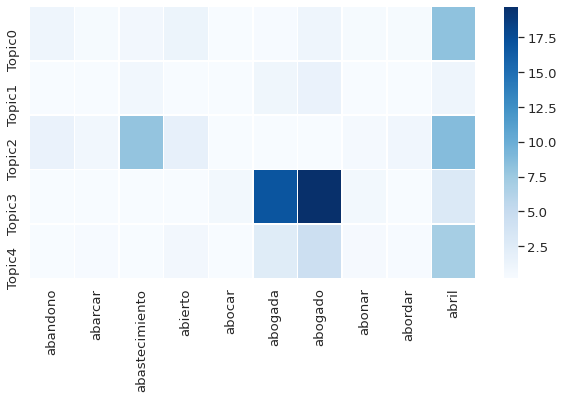

In [18]:
import seaborn as sns
plt.figure(figsize=(10,5))
sns.set(font_scale=1.2)
sns.heatmap(
            df_topic_words01.iloc[:,:10],
            linewidth=0.5,
            cmap="Blues",
            annot=False,
            fmt=".2g",
            cbar=True
        )

___
Imprimr las primeras 10 palabras asociadas a cada tópico
___

In [19]:
%%time

# Función para imprimir las 10 principales palabras  por cada tópico
def print_topic_words(tfidf_model, lda_model, n_words):
    words = np.array(tfidf_model.get_feature_names())
    topic_words = []
    # Por cada tópico se considera el peso
    for topic_words_weights in lda_model.components_:
        top_words = topic_words_weights.argsort()[::-1][:n_words]
        topic_words.append(words.take(top_words))
    return topic_words

topic_keywords = print_topic_words(tfidf_model=tfidf_model, lda_model=lda, n_words=10)        

df_topic_words = pd.DataFrame(topic_keywords)
df_topic_words.columns = ['Word '+str(i) for i in range(df_topic_words.shape[1])]
df_topic_words.index = ['Topic '+str(i) for i in range(df_topic_words.shape[0])]
df_topic_words.T



CPU times: user 6.7 ms, sys: 0 ns, total: 6.7 ms
Wall time: 5.88 ms


,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
Word 0,municipalidad,designar,decreto,fiscal,judicial
Word 1,ordenanza,cargo,regional,electoral,justicia
Word 2,municipal,ministerio,salud,fiscalía,corte
Word 3,gerencia,designación,nacional,elección,superior
Word 4,tributario,ministro,ministerio,provincial,osinergmin
Word 5,distrital,ejecutivo,supremo,acta,resolución
Word 6,concejo,señor,general,distrito,juez
Word 7,alcalde,general,presupuesto,penal,juzgado
Word 8,administrativo,confianza,público,junta,poder
Word 9,alcaldía,concesión,resolución,voto,cultural


In [20]:
df_topic_words01.iloc[:,:5]

,abandono,abarcar,abastecimiento,abierto,abocar
Topic0,1.189802,0.423666,0.747941,1.273353,0.200001
Topic1,0.200032,0.200059,0.843995,0.201502,0.200004
Topic2,1.512918,0.875569,8.043798,1.841006,0.200001
Topic3,0.200228,0.203078,0.200096,0.200608,0.678552
Topic4,0.200369,0.337137,0.201928,0.783185,0.200002
